# Machine Learning - Practical 2



In [1]:
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression

# Task 1: The Data

We use the mouse protein expression dataset: https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression
Please use the code provided below for loading the dataset.

In [25]:
file = 'Data_Cortex_Nuclear.csv'
df = pd.read_csv(file)

N = 10  # use only every tenth sample
X_all = df.iloc[::N,1:65].to_numpy()
t_all = (df['Behavior'] == 'S/C').to_numpy()[::N]

idx = ~np.any(np.isnan(X_all), axis=1)
X_all = X_all[idx]
t_all = t_all[idx]
t_all

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

### Tasks 1.1: Dataset Exploration 

Let's start with a bit of exploration.

- How many samples / features are provided?
- How many labels does the dataset have?
- What is the value range of the individuals predictors?
- Visualize the 10 first samples of the dataset in a form that highlights their differences.
- Visualize the variance of each predictor.

(105, 64)
1   min: 0.168493351   max: 2.480315709
2   min: 0.292269472   max: 2.48868391
3   min: 0.198158702   max: 0.446958318
4   min: 1.564858491   max: 3.174743218
5   min: 1.991141365   max: 6.465180208
6   min: 0.165285957   max: 0.327951884
7   min: 0.124793218   max: 0.247873848
8   min: 1.555074815   max: 7.464070214
9   min: 0.134882362   max: 0.29483803
10   min: 0.790957854   max: 4.497337391
11   min: 0.179529803   max: 3.289273488
12   min: 0.191192954   max: 0.402374203
13   min: 0.212873563   max: 0.453450025
14   min: 0.179693962   max: 0.371636594
15   min: 0.572641509   max: 1.118509469
16   min: 0.345716573   max: 1.294251665
17   min: 0.301608579   max: 2.245522781
18   min: 0.716981132   max: 2.717151093
19   min: 0.308613634   max: 0.594835681
20   min: 0.33491062   max: 1.028539241
21   min: 0.152856934   max: 2.133415747
22   min: 0.250328803   max: 0.551381999
23   min: 0.125237469   max: 0.275403609
24   min: 0.68254717   max: 2.658019489
25   min: 1.4998868

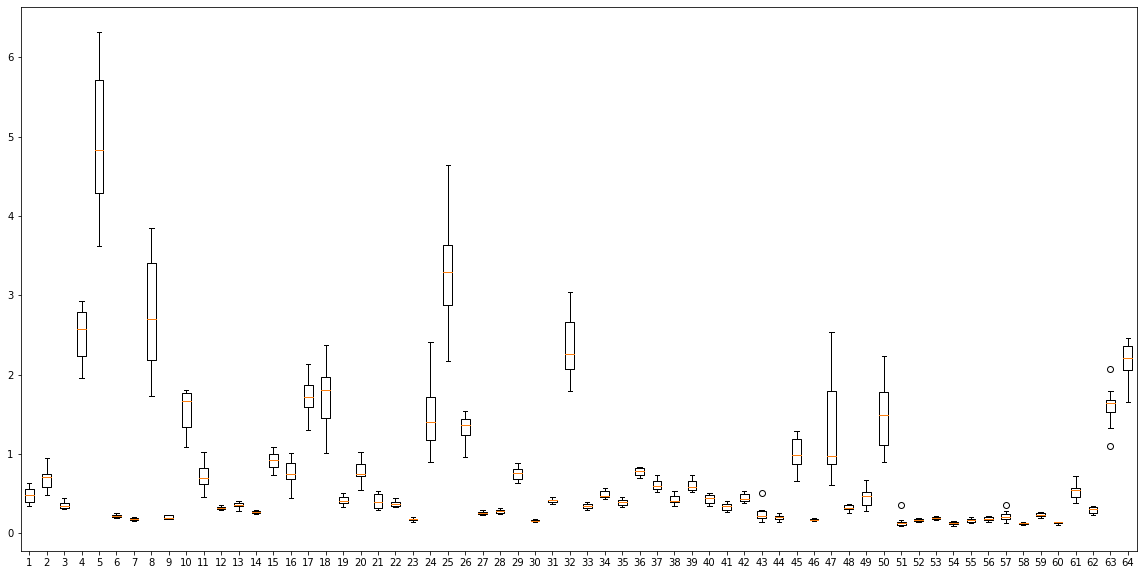

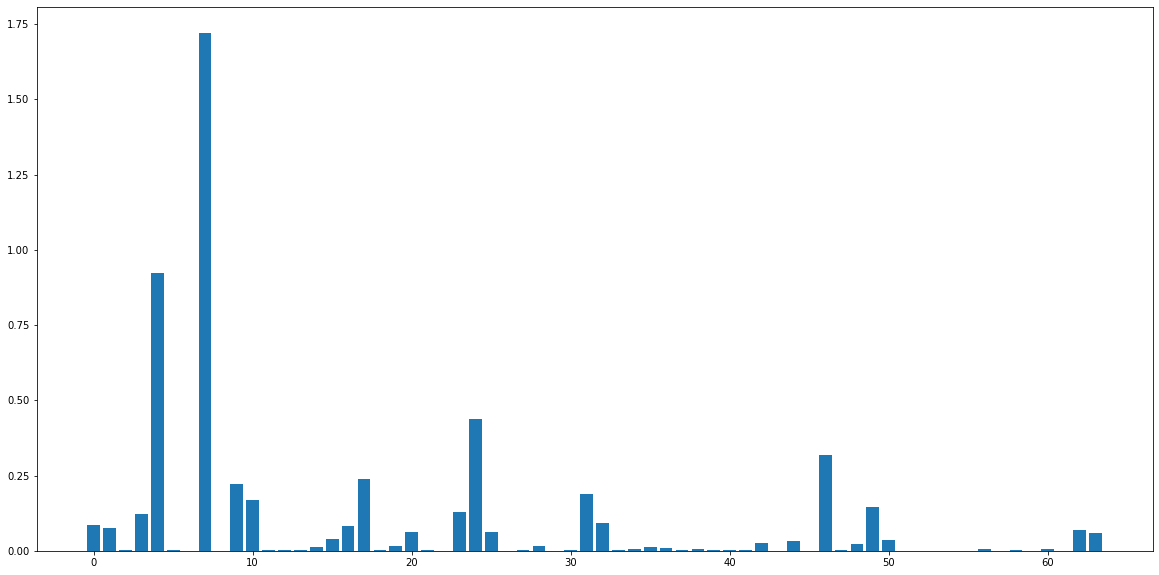

In [3]:
# data exploration
print(X_all.shape)
for i in range(X_all.shape[1]):
    print(str(i+1)+"   min: "+str(min(X_all[:,i]))+"   max: "+str(max(X_all[:,i])))
x=np.arange(X_all.shape[1])
fig = plt.figure()
plt.boxplot(X_all[:10,:])
fig.set_size_inches(20,10)
plt.show()
fig2 = plt.figure()
plt.bar(x,np.var(X_all,axis=0))
fig2.set_size_inches(20,10)
plt.show()

**Task 1.2: Data Preprocessing**:  
- Write a function `split_data(X, y, frac, seed)` that first shuffles your training data and then splits it into a training and a test set. `frac` determines the relative size of the test dataset, `seed` makes sure we get reproducible 
results.  
- Write a function `preprocess(X)` which zero-centers your data and sets variance to one (per-feature).

In [24]:
def split_data(X, y, frac=0.3, seed=None):
    if seed is not None:
        np.random.seed(seed)


    # ---------------- INSERT CODE ----------------------
    X=np.take(X,np.random.RandomState(seed=seed).permutation(X.shape[0]),axis=0,out=X)
    y=np.take(y,np.random.RandomState(seed=seed).permutation(y.shape[0]),axis=0,out=y)
    l0=int(X.shape[0]*(1-frac))
    l1=int(y.shape[0]*(1-frac))
    X_train=X[:l0,:]
    X_test=X[l0:,:]
    y_train=y[:l1]
    y_test=y[l1:]
    # ---------------- END CODE -------------------------
    
    return X_train, X_test, y_train, y_test
    
    
def preprocess(X):

    # ---------------- INSERT CODE ----------------------
    normed = (X - X.mean(axis=0)) / X.std(axis=0)


    # ---------------- END CODE -------------------------
    
    return normed



# Task 2: LDA

First, use Linear Discriminant Analysis to separate the classes. As discussed in the Bishop in pg. 186-189, we can find a weight vector $\vec{w}$ that performs a projection of the i-th input data point $\vec{x}_i$

$p =   \vec{w}^T \vec{x}_i$

that optimally separates the classes.

Use the analytic solution to compute the optimal weights $\vec{w}$ from the training set data. 

### Task 2.1

1. Implement a function `compute_lda_weights(x, y)` manually, which carries out LDA using the data `x,y`. 
2. Apply this function on your training data.
3. Visualize the obtained weight vector $\vec{w}$ using a `plt.stemplot`.

Text(0.5, 0, 'predictors')

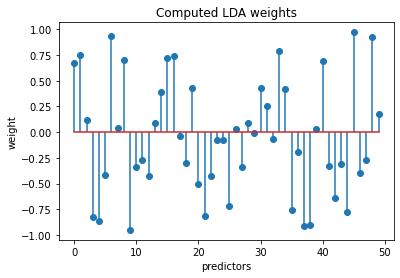

In [5]:
# example usage of stemplot
w_lda = np.random.uniform(-1, 1, 50)  # example data
plt.stem(w_lda.flatten(), use_line_collection=True)
plt.title('Computed LDA weights')
plt.ylabel('weight')
plt.xlabel('predictors')

In [6]:
def compute_lda_weights(X, y, alpha=0.001):
    '''function that computes regularized LDA weights for a two class problem

    input:
        x: training data -- array with shape (n_examples x n_features)
        y: training data class label -- flat array with length (n_examples)
        alpha: regularization strength -- float

    output:
        m0: mean of the training examples of class 0 -- flat array with length (n_features)
        m1: mean of the training examples of class 1 -- flat array with length (n_features)
        mdiff: difference of the two class means -- flat array with length (n_features)
        w: regularized LDA weight vector -- flat array with length (n_features)
        '''

    # ---------------- INSERT CODE ----------------------
    m0=np.mean(X[y==False],axis=0)
    m1=np.mean(X[y==True],axis=0)
    Sw=np.zeros((X.shape[1],X.shape[1]))
    for i in (X[y==False]):
        tmp=np.asmatrix(i-m0)
        Sw=Sw + tmp.T @ tmp
    for i in (X[y==True]):
        tmp=np.asmatrix(i-m1)
        Sw=Sw + tmp.T @ tmp
    w=np.linalg.inv(Sw) @ (m1-m0)
    mdiff=m1-m0
    # ---------------- END CODE -------------------------

    return m0, m1, mdiff, np.ravel(w)

In [7]:
# split dataset and apply LDA
X_train, X_test, y_train, y_test=split_data(X_all, t_all, 0.3, 2)
m0,m1,mdiff,w = compute_lda_weights(X_train,y_train)

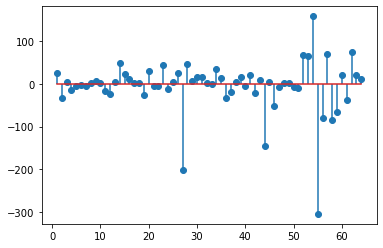

In [8]:
# visualize LDA weights using stemplot
plt.stem(np.arange(len(w))+1,w)
plt.show()

### Task 2.2

Project the training data and the test data on $\vec{w}$. Visualize the class separation using a two-color histogram. 
- Is the class separation good?
- Is there a big difference between training and test data?

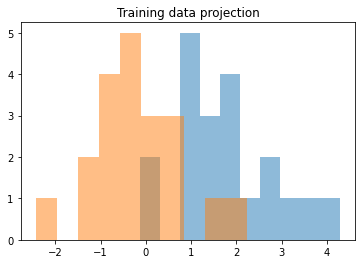

In [9]:
# example usage of histogram
a, b = np.random.normal(2, 1, 20), np.random.normal(0, 1, 20)  # example data

plt.title('Training data projection')
_ = plt.hist(a,label='class 0',alpha=0.5)
_ = plt.hist(b,label='class 1',alpha=0.5)

In [10]:
# compute projections for training and test data
p1=[]
for i in range(len(X_train)):
    p1.append(w.dot(X_train[i,:]))
p2=[]
for i in range(len(X_test)):
    p2.append(w.dot(X_test[i,:]))    
p1=np.array(p1)
p2=np.array(p2)

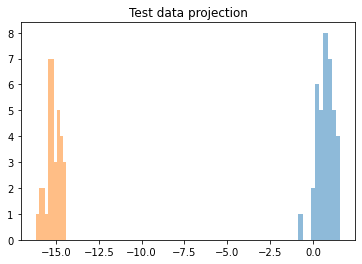

In [11]:
# visualize projections using histogram
plt.title('Test data projection')
_ = plt.hist(p1[y_train==True],label='class 0',alpha=0.5)
_ = plt.hist(p1[y_train==False],label='class 1',alpha=0.5)

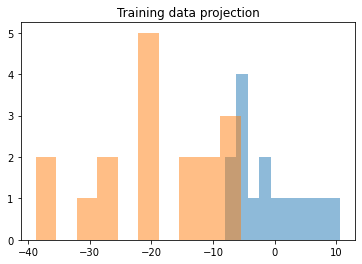

In [12]:
plt.title('Training data projection')
_ = plt.hist(p2[y_test==True],label='class 0',alpha=0.5)
_ = plt.hist(p2[y_test==False],label='class 1',alpha=0.5)

### Task 2.3

Now we make class predictions based on the projections. Read https://en.wikipedia.org/wiki/Linear_discriminant_analysis#Fisher's_linear_discriminant and compute threshold $c$ for the projected values $p$ based on the training data. Print the value of $c$ and plot $c$ into the histograms of projected values you made before!

Use $c$ to assign class labels for training and test set. Determine the classification errors (in terms of accuracy) on both datasets and print them. 

In [13]:
def compute_threshold_LDA(m0, m1, w):
    '''Compute the optimal threshold for LDA .

    input:
        m0, m1: mean vectors of the two classes -- flat array with length (n_features)
        w: weight vector of LDA -- flat array with length (n_features)

    output:
        c: the optimal threshold for LDA 
    '''

    # ---------------- INSERT CODE ----------------------

    c=w.dot(0.5*(m0+m1))

    # ---------------- END CODE -------------------------
  
    return c


def score_LDA(x_proj, y, c):
    '''Compute the accuracy given a threshold.

    input:
        x_proj: projected data -- flat array with length (n_examples)    
        y: class labels -- flat array with length (n_examples)
        c: optimal threshold for LDA - scalar

    output:
        y_hat: class label predicitons of LDA model -- flat array with length (n_examples)
        acc: classification accuracy
    '''
    # ---------------- INSERT CODE ----------------------
    count=0
    for i in range(len(x_proj)):
        if(x_proj[i]>=c and y[i]==True or x_proj[i]<=c and y[i]==False):
            count=count+1
    acc=count/len(y)
    y_hat=0


    # ---------------- END CODE -------------------------
    
    return y_hat, acc

In [14]:
# compute optimal threshold
c=compute_threshold_LDA(m0,m1,w)

In [15]:
# compute classification accuracy
y_hat,acc=score_LDA(p2,y_test,c)
print(acc)

0.875


In [16]:
y_hat,acc=score_LDA(p1,y_train,c)
print(acc)

1.0


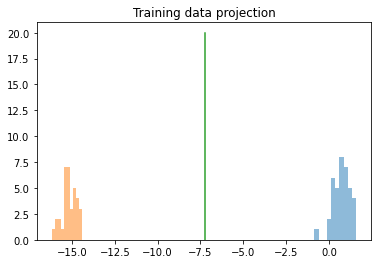

In [17]:
# visualize treshold in histogram
plt.title('Training data projection')
_ = plt.hist(p1[y_train==True],label='class 0',alpha=0.5)
_ = plt.hist(p1[y_train==False],label='class 1',alpha=0.5)
_ = plt.plot([c,c],[0,20])

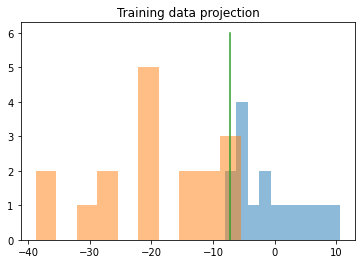

In [18]:
plt.title('Training data projection')
_ = plt.hist(p2[y_test==True],label='class 0',alpha=0.5)
_ = plt.hist(p2[y_test==False],label='class 1',alpha=0.5)
_ = plt.plot([c,c],[0,6])

## Task 3: Logistic Regression

Next, we will consider classification using Logistic Regression. 

For this task, we will use a different dataset:  
It consists of activations from a convolutional neural network (ResNet18) for images of cats and dogs.
The dataset contains 2,000 samples (i.e. CNN activations) and 256 features (i.e. the CNN activations have 256 dimensions). A target value of 0 indicates a cat, 1 a dog.

Below, you find all imports that are necessary.


In [28]:
X_all1, t_all1 = pickle.load(open('cnn_features.pickle', 'rb'))
t_all1

array([1, 1, 0, ..., 0, 1, 0])

### Task 3.0: Normalize and split the data

Make sure the data has has zero mean and variance 1 per feature.

In [20]:
# normalize data
X_all1=preprocess(X_all1)
X_train1, X_test1, y_train1, y_test1=split_data(X_all1, t_all1, 0.3, 2)

### Task 3.1: Iterative Reweighted Least Squares**

1. Implement the IRLS algorithm and output at each iteration the current training accuracy. Remember the weight are updated according to:
$$ w' = w - ( \Phi^T R \Phi ) ^ {-1} \Phi^T (y - t)$$
where $y$ is the prediction, $t$ the ground truth target, $R$ the weighting matrix and $\Phi$ the design matrix.  

    Hints:  
    (a) There is a bias term in logistic regression  
    (b) Use a small value for weight init to avoid numerical problems.


2. Apply the IRLS algorithm on data and compute the test accuracy.
3. Compare the results of your implementation to the sklearn implementation of `LogisticRegression(penalty='none')`. Do you get the same result?

In [21]:
# IRLS

# 1.

# function to compute the accuracy of weights w, tested on X,t

def Accuracy(X, t, w):
     
    pred = X.dot(w)
    odds = np.exp(pred)
    pred = odds/(1+odds)

    miss_count = 0
    for j in range(len(pred)):
        if pred[j] < 0.5: pred[j] = 0
        else: pred[j] = 1
        if pred[j] != t[j]: miss_count += 1
    return (1-(miss_count/len(t)))

# function to fit weights through IRLS

def fit_IRLS(X, t, iterations = 25, return_w = False):

    w = np.array([0]*X.shape[1], dtype='float64')
    w_init = np.mean(t)
    for i in range(iterations):
        h = w_init + X.dot(w)
        p = 1/(1+np.exp(-h))
        
        r = p*(1-p)
        R = np.diag(r)
        arb_small = np.ones_like(r, dtype='float64')*.000001
        z = h + np.divide((t-p), r, out=arb_small, where=r!=0)
        Xt = np.transpose(X)
        XtR = Xt.dot(R)
        XtRX = XtR.dot(X)
        inverse_of_XtRX = np.linalg.inv(XtRX)
        inverse_of_XtRX_Xt = inverse_of_XtRX.dot(Xt)
        inverse_of_XtRX_XtR = inverse_of_XtRX_Xt.dot(R)
        w = inverse_of_XtRX_XtR.dot(z)
      
        print('Accuracy in iteration ' + str(i+1) + ': ' + str(Accuracy(X, t, w)))
    
    if return_w: return w

#fit_IRLS(X_all, t_all)


weigth1 = fit_IRLS(X_train1, y_train1, iterations = 25, return_w = True)
print('Accuracy IRLS: ' + str(Accuracy(X_test1, y_test1, weigth1)))


# 3.

clf = LogisticRegression(penalty = 'none').fit(X_train1, y_train1)
print('Accuracy sklearn: ' + str(clf.score(X_test1, y_test1)))


Accuracy in iteration 1: 0.9485714285714286
Accuracy in iteration 2: 0.9628571428571429
Accuracy in iteration 3: 0.9657142857142857
Accuracy in iteration 4: 0.9778571428571429
Accuracy in iteration 5: 0.9864285714285714
Accuracy in iteration 6: 0.9985714285714286
Accuracy in iteration 7: 1.0
Accuracy in iteration 8: 1.0
Accuracy in iteration 9: 1.0
Accuracy in iteration 10: 1.0
Accuracy in iteration 11: 1.0
Accuracy in iteration 12: 1.0
Accuracy in iteration 13: 1.0
Accuracy in iteration 14: 1.0
Accuracy in iteration 15: 1.0
Accuracy in iteration 16: 1.0
Accuracy in iteration 17: 1.0
Accuracy in iteration 18: 1.0
Accuracy in iteration 19: 1.0
Accuracy in iteration 20: 1.0
Accuracy in iteration 21: 1.0
Accuracy in iteration 22: 1.0
Accuracy in iteration 23: 1.0
Accuracy in iteration 24: 1.0
Accuracy in iteration 25: 1.0
Accuracy IRLS: 0.85
Accuracy sklearn: 0.8683333333333333


/tmp/ipykernel_306/2978080539.py:28: RuntimeWarning: overflow encountered in exp
  p = 1/(1+np.exp(-h))


### Task 3.2: Logistic Regression with Regularization

1. Set sklearn's penalty parameter to `l1` and `l2`. Use the range `np.linspace(0.02, 1, 25)` for the parameter `C`, which controls the strength of regularization. Where is the regularization strongest, for small or big `C`?   
Hint: For `l1` regularization you can use the `saga` solver.
2. Plot strength of regularization over accuracy. Does regularization improve the scores?
3. Visualize the coefficients (or just a subset of all coefficient for a better overview) of the regularized settings and the unregularized setting. What do you observe?
3. Compare the coefficients to the LDA weights.

In [22]:

c_range = np.linspace(0.02, 1, 25)     #c is the inverse of the regularization strength; small c -> strong reguralization 

l1_clf = []
l2_clf = []
l1_acc = []
l2_acc = []

for i in c_range:
    l1_clf.append([])
    l2_clf.append([])
    l1_acc.append([])
    l2_acc.append([])

    
# Logistic Regression for every strength value

for i in range(len(c_range)):
    l1_clf[i] = LogisticRegression(penalty = 'l1', solver = 'saga', C = c_range[i], max_iter = 450).fit(X_train1, y_train1)
    l2_clf[i] = LogisticRegression(penalty = 'l2', C = c_range[i], max_iter = 450).fit(X_train1, y_train1)
    l1_acc[i] = l1_clf[i].score(X_test1, y_test1)
    l2_acc[i] = l2_clf[i].score(X_test1, y_test1)
    


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

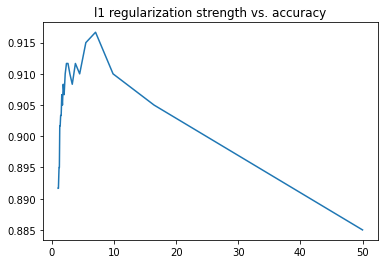

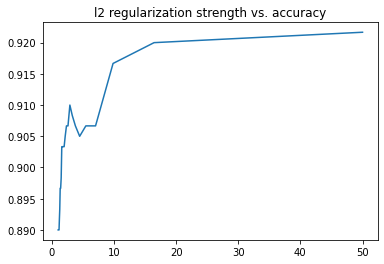

In [23]:
# 2.
# plotting the regularizations strength for l1/l2 vs the accuracy
plt.plot((1/c_range), l1_acc)
plt.title('l1 regularization strength vs. accuracy')
plt.show()
plt.plot((1/c_range), l2_acc)
plt.title('l2 regularization strength vs. accuracy')
plt.show()
